# Model LSTM - Prognozowanie cen akcji

## 1. Import bibliotek i przygotowanie środowiska

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

# Dodaj ścieżkę do modułów
sys.path.append('..')

# Import modułów
from src.lstm_model import LSTMModel, ImprovedLSTMTrainer, prepare_data_for_lstm
from src.lstm_analysis import LSTMAnalysis
from src.utils import create_directories, save_model

# Sprawdź GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Używane urządzenie: {device}")
if device.type == 'cuda':
    print(f"🚀 Nazwa GPU: {torch.cuda.get_device_name(0)}")

🖥️ Używane urządzenie: cuda
🚀 Nazwa GPU: Quadro M1200


## 2. Wczytanie i przygotowanie danych

In [2]:
# Ścieżka do danych
data_path = r"C:\Users\pawli\OneDrive\Pulpit\sieci\Projektowanie_i_zastosowania_sieci_neuronowych\data\data\processed\cleaned_data.csv"

# Wczytaj dane
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])

print(f"✅ Wczytano {len(df)} rekordów")
print(f"📊 Zakres dat: {df['Date'].min().date()} - {df['Date'].max().date()}")

✅ Wczytano 2623 rekordów
📊 Zakres dat: 2015-01-02 - 2025-06-06


## 3. Dodanie cech technicznych

In [3]:
# Sortowanie chronologiczne
df = df.sort_values('Date').reset_index(drop=True)

# Podstawowe cechy
df['Returns'] = df['Close/Last'].pct_change()
df['Log_Returns'] = np.log(df['Close/Last'] / df['Close/Last'].shift(1))

# Cechy względne
df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close/Last']
df['Price_Position'] = (df['Close/Last'] - df['Low']) / (df['High'] - df['Low'] + 1e-8)

# Średnie kroczące
df['MA_5'] = df['Close/Last'].rolling(window=5).mean()
df['MA_20'] = df['Close/Last'].rolling(window=20).mean()
df['Price_MA5_Ratio'] = df['Close/Last'] / df['MA_5']
df['Price_MA20_Ratio'] = df['Close/Last'] / df['MA_20']

# Momentum
df['Momentum_5'] = df['Close/Last'] / df['Close/Last'].shift(5) - 1
df['Momentum_10'] = df['Close/Last'] / df['Close/Last'].shift(10) - 1

# Zmienność
df['Volatility_5'] = df['Returns'].rolling(window=5).std()
df['Volatility_20'] = df['Returns'].rolling(window=20).std()

# RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close/Last'])
df['RSI_normalized'] = (df['RSI'] - 50) / 50

# Target - następny zwrot
df['Target_Return'] = df['Returns'].shift(-1)

# Usuń NaN
df = df.dropna()
print(f"📊 Liczba wierszy po dodaniu cech: {len(df)}")

📊 Liczba wierszy po dodaniu cech: 2602


## 4. Przygotowanie danych dla LSTM

In [4]:
# Lista cech
feature_cols = [
    'Returns', 'Volume_Ratio', 'Daily_Range', 'Price_Position',
    'Price_MA5_Ratio', 'Price_MA20_Ratio', 'Momentum_5', 'Momentum_10',
    'Volatility_5', 'Volatility_20', 'RSI_normalized'
]

# Parametry
seq_length = 30
test_size = 0.2
val_size = 0.1
batch_size = 128

# Przygotuj dane
data = prepare_data_for_lstm(
    df=df,
    feature_cols=feature_cols,
    target_col='Target_Return',
    seq_length=seq_length,
    test_size=test_size,
    val_size=val_size,
    batch_size=batch_size,
    shuffle=False  # Ważne dla danych czasowych!
)

print(f"\n📊 PODSUMOWANIE DANYCH:")
print(f"Liczba cech: {data['input_size']}")
print(f"Próbki treningowe: {len(data['X_train'])}")
print(f"Próbki walidacyjne: {len(data['X_val'])}")
print(f"Próbki testowe: {len(data['X_test'])}")


📊 PODSUMOWANIE DANYCH:
Liczba cech: 11
Próbki treningowe: 1800
Próbki walidacyjne: 257
Próbki testowe: 515


## 5. Definicja i trenowanie modelu

In [5]:
# Parametry modelu
model_params = {
    'input_size': data['input_size'],
    'hidden_size': 64,
    'num_layers': 2,
    'output_size': 1,
    'dropout': 0.3
}

# Utwórz model
lstm_model = LSTMModel(**model_params)
lstm_model = lstm_model.to(device)

print(f"🧠 Model LSTM utworzony")
print(f"Parametry: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Parametry treningu
training_params = {
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'epochs': 150,
    'early_stopping_patience': 20
}

# Inicjalizacja trenera
trainer = ImprovedLSTMTrainer(
    model=lstm_model,
    learning_rate=training_params['learning_rate'],
    device=device
)

print("\n🚀 Rozpoczynam trenowanie...")
print(f"Epoki: {training_params['epochs']}")
print(f"Early stopping: {training_params['early_stopping_patience']}")
print(f"Learning rate: {training_params['learning_rate']}")

# Trenuj model
history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=training_params['epochs'],
    early_stopping_patience=training_params['early_stopping_patience'],
    verbose=True
)

print("\n✅ Trenowanie zakończone!")

🧠 Model LSTM utworzony
Parametry: 53,057

🚀 Rozpoczynam trenowanie...
Epoki: 150
Early stopping: 20
Learning rate: 0.001
Epoka 1/150, Strata treningowa: 0.100531, Strata walidacyjna: 0.006225
Epoka 11/150, Strata treningowa: 0.002071, Strata walidacyjna: 0.002092
Epoka 21/150, Strata treningowa: 0.001905, Strata walidacyjna: 0.001981
Epoka 31/150, Strata treningowa: 0.001844, Strata walidacyjna: 0.001946
Epoka 41/150, Strata treningowa: 0.001899, Strata walidacyjna: 0.001904
Epoka 51/150, Strata treningowa: 0.001834, Strata walidacyjna: 0.001926
Early stopping po 55 epokach

✅ Trenowanie zakończone!


## 6. Analiza wyników


🚀 PEŁNA ANALIZA MODELU LSTM

📈 HISTORIA TRENINGU:


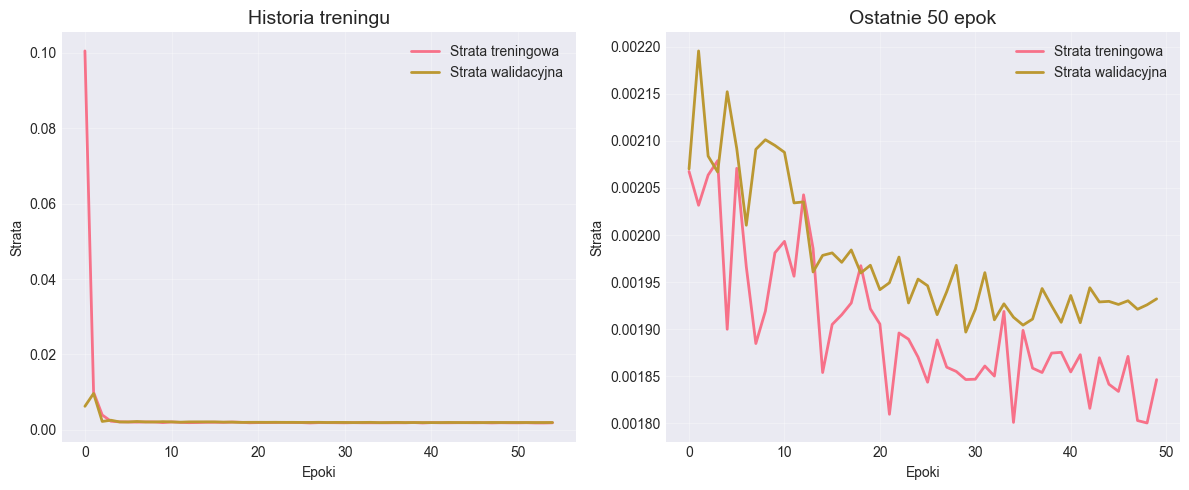

📊 Końcowa strata treningowa: 0.001847
📊 Końcowa strata walidacyjna: 0.001932
📊 Liczba epok: 55

📊 WIZUALIZACJA PREDYKCJI:


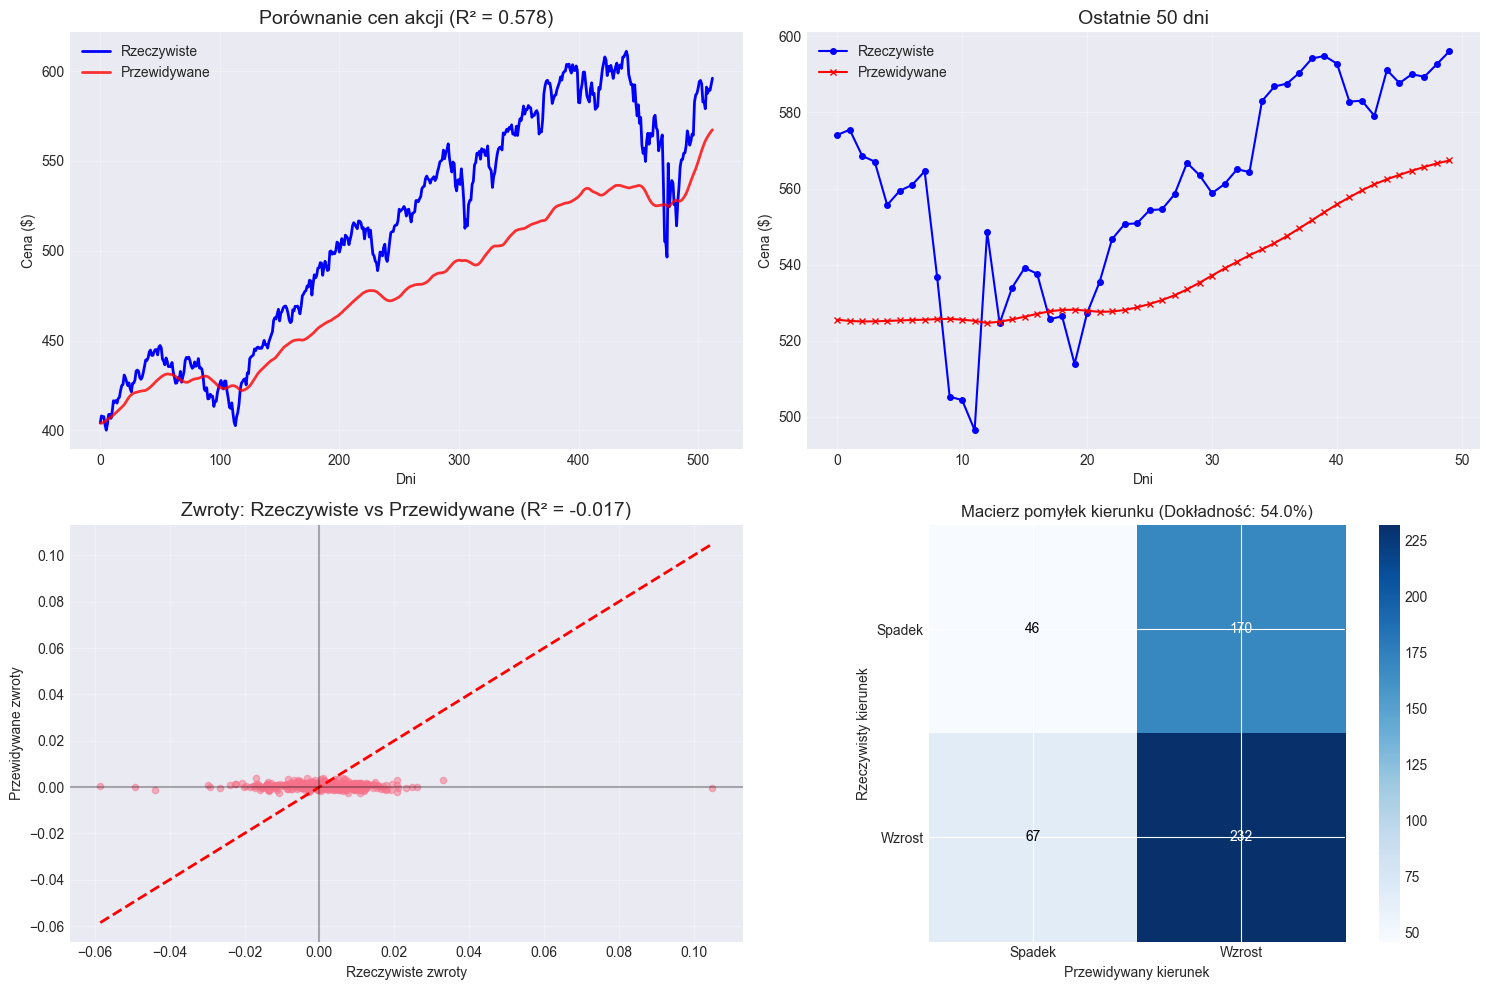


🔍 ANALIZA BŁĘDÓW:


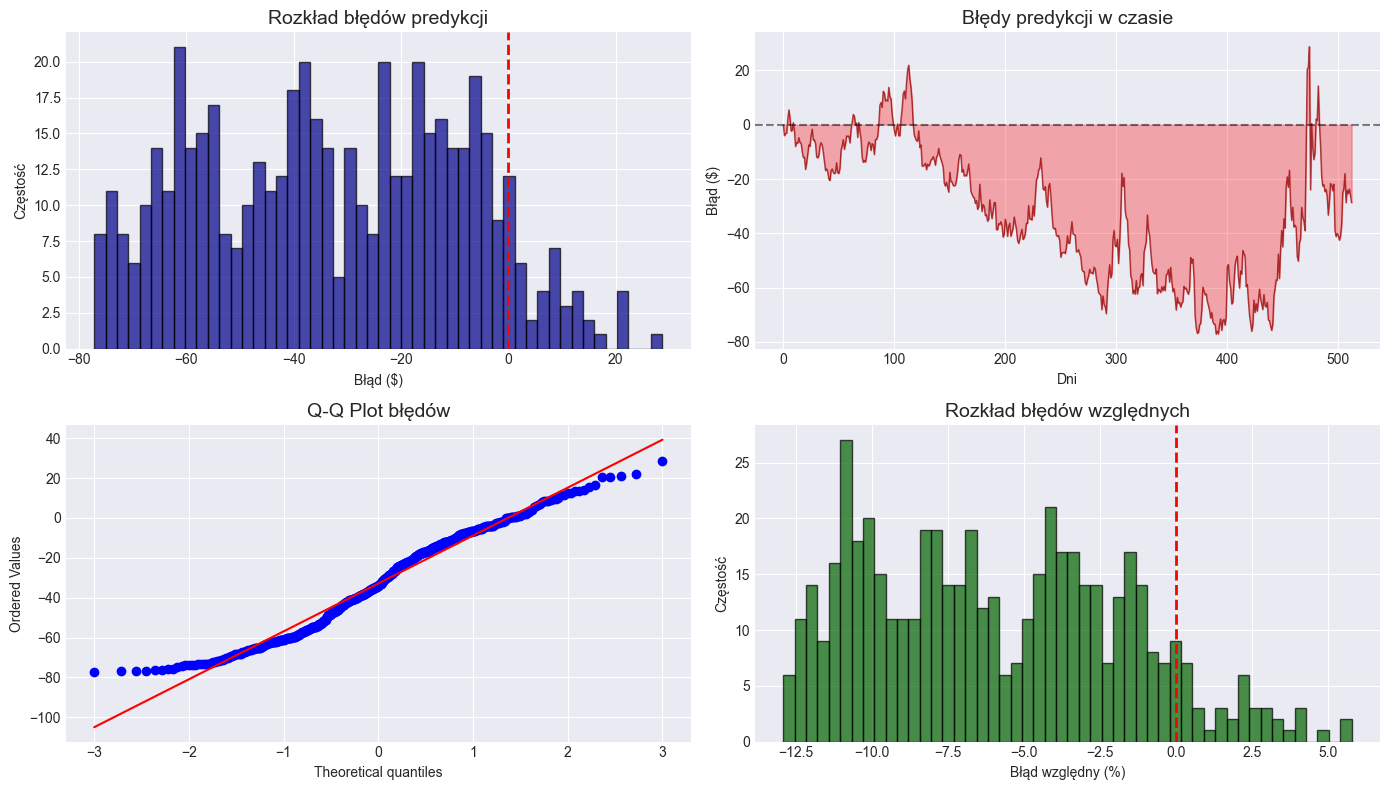


📊 ANALIZA BŁĘDÓW:
Średni błąd: $-32.86
Mediana błędu: $-33.99
Odchylenie standardowe błędu: $24.24
Średni błąd względny: -5.99%
MAPE: 6.31%

🔍 WALIDACJA PREDYKCJI

📈 ANALIZA ZWROTÓW:
Średnia przewidywanych zwrotów: 0.000664
Std przewidywanych zwrotów: 0.001037
Min/Max przewidywanych: -0.002632 / 0.003857

Średnia rzeczywistych zwrotów: 0.000818
Std rzeczywistych zwrotów: 0.010323

📊 METRYKI NA CENACH:
R²: 0.578
RMSE: $40.83
MAE: $34.26

📊 METRYKI NA ZWROTACH:
R²: -0.017
MSE: 0.000108

🎯 DOKŁADNOŚĆ KIERUNKU: 54.0%

📋 OCENA MODELU:
❌ Model ma problemy z przewidywaniem kierunku
✅ Pozytywne R² na cenach
⚠️ Model ma trudności z przewidywaniem zwrotów


📋 PODSUMOWANIE:
Model: 53,057 parametrów
Dokładność kierunku: 54.0%
R² (ceny): 0.578
RMSE: $40.83


In [6]:
# Utwórz obiekt analizy
analysis = LSTMAnalysis(
    model=lstm_model,
    trainer=trainer,
    data=data,
    df=df
)

# Wykonaj pełną analizę
summary = analysis.plot_all_analysis()

## 7. Zapisanie modelu

In [7]:
# Przygotuj metadane
metadata = {
    'model_params': model_params,
    'training_params': training_params,
    'feature_cols': feature_cols,
    'target_col': 'Target_Return',
    'seq_length': seq_length,
    'metrics': summary['metrics_prices'],
    'metrics_returns': summary['metrics_returns'],
    'direction_accuracy': summary['direction_accuracy'],
    'data_info': summary['data_info']
}

# Zapisz model
model_path = '../models/lstm/lstm_model_clean.pth'
save_model(
    model=lstm_model,
    path=model_path,
    metadata=metadata
)

print(f"\n💾 Model zapisany: {model_path}")
print(f"📊 R² (ceny): {metadata['metrics']['r2']:.3f}")
print(f"🎯 Dokładność kierunku: {metadata['direction_accuracy']:.1%}")

Model zapisany w ../models/lstm/lstm_model_clean.pth

💾 Model zapisany: ../models/lstm/lstm_model_clean.pth
📊 R² (ceny): 0.578
🎯 Dokładność kierunku: 54.0%


## 8. Podsumowanie i wnioski

In [8]:
print("\n" + "="*60)
print("📊 PODSUMOWANIE EKSPERYMENTU")
print("="*60)

print(f"\n🏗️ ARCHITEKTURA:")
print(f"- Hidden size: {model_params['hidden_size']}")
print(f"- Liczba warstw: {model_params['num_layers']}")
print(f"- Dropout: {model_params['dropout']}")
print(f"- Liczba cech: {model_params['input_size']}")

print(f"\n📈 WYNIKI:")
print(f"- R² na cenach: {summary['metrics_prices']['r2']:.3f}")
print(f"- RMSE: ${summary['metrics_prices']['rmse']:.2f}")
print(f"- Dokładność kierunku: {summary['direction_accuracy']:.1%}")

print(f"\n💡 WNIOSKI:")
if summary['direction_accuracy'] > 0.55:
    print("✅ Model przewiduje kierunek ruchu lepiej niż losowo")
else:
    print("⚠️ Model ma trudności z przewidywaniem kierunku")

if summary['metrics_prices']['r2'] > 0:
    print("✅ Model osiągnął pozytywne R² na cenach")
else:
    print("⚠️ Model nie radzi sobie z dokładnym przewidywaniem cen")

print("\n🔄 MOŻLIWE ULEPSZENIA:")
print("1. Zwiększenie liczby cech (więcej wskaźników technicznych)")
print("2. Architektura bidirectional LSTM")
print("3. Dodanie warstw attention")
print("4. Ensemble różnych modeli")
print("5. Optymalizacja hiperparametrów (Optuna)")

print("\n" + "="*60)


📊 PODSUMOWANIE EKSPERYMENTU

🏗️ ARCHITEKTURA:
- Hidden size: 64
- Liczba warstw: 2
- Dropout: 0.3
- Liczba cech: 11

📈 WYNIKI:
- R² na cenach: 0.578
- RMSE: $40.83
- Dokładność kierunku: 54.0%

💡 WNIOSKI:
⚠️ Model ma trudności z przewidywaniem kierunku
✅ Model osiągnął pozytywne R² na cenach

🔄 MOŻLIWE ULEPSZENIA:
1. Zwiększenie liczby cech (więcej wskaźników technicznych)
2. Architektura bidirectional LSTM
3. Dodanie warstw attention
4. Ensemble różnych modeli
5. Optymalizacja hiperparametrów (Optuna)



## 9. Dodatkowe eksperymenty


🔬 TEST RÓŻNYCH DŁUGOŚCI SEKWENCJI:

Testuję seq_length = 15...
Val loss: 0.001512

Testuję seq_length = 30...
Val loss: 0.002082

Testuję seq_length = 45...
Val loss: 0.002044

Testuję seq_length = 60...
Val loss: 0.002045


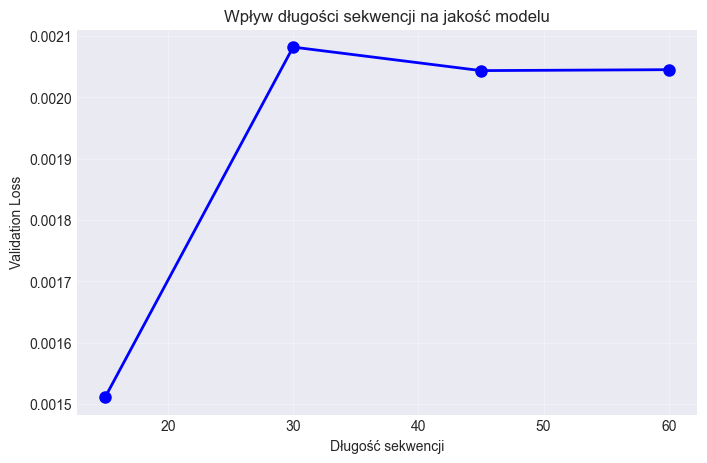


✅ Najlepsza długość sekwencji: 15


In [9]:
seq_lengths = [15, 30, 45, 60]
results = []

print("\n🔬 TEST RÓŻNYCH DŁUGOŚCI SEKWENCJI:")
for seq_len in seq_lengths:
    print(f"\nTestuję seq_length = {seq_len}...")
    
    # Przygotuj dane
    data_test = prepare_data_for_lstm(
        df=df,
        feature_cols=feature_cols,
        target_col='Target_Return',
        seq_length=seq_len,
        test_size=test_size,
        val_size=val_size,
        batch_size=batch_size,
        shuffle=False
    )
    
    # Prosty model do testu
    test_model = LSTMModel(
        input_size=data_test['input_size'],
        hidden_size=32,
        num_layers=1,
        dropout=0.2
    ).to(device)
    
    # Szybkie trenowanie
    test_trainer = ImprovedLSTMTrainer(test_model, learning_rate=0.001)
    test_trainer.fit(
        data_test['train_loader'],
        data_test['val_loader'],
        epochs=50,
        verbose=False
    )
    
    # Zapisz wynik
    final_val_loss = test_trainer.val_losses[-1]
    results.append({
        'seq_length': seq_len,
        'val_loss': final_val_loss
    })
    print(f"Val loss: {final_val_loss:.6f}")

# Pokaż wyniki
import matplotlib.pyplot as plt

seq_lens = [r['seq_length'] for r in results]
val_losses = [r['val_loss'] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(seq_lens, val_losses, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Długość sekwencji')
plt.ylabel('Validation Loss')
plt.title('Wpływ długości sekwencji na jakość modelu')
plt.grid(True, alpha=0.3)
plt.show()

best_seq = seq_lens[np.argmin(val_losses)]
print(f"\n✅ Najlepsza długość sekwencji: {best_seq}")